# Assignment 1
## Part A - Titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")

#### Exploratory data analysis

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
for column in train.select_dtypes(exclude=[np.number]).columns.tolist():
    print("{}: {} unique values".format(column, train[column].nunique()))  

Name: 891 unique values
Sex: 2 unique values
Ticket: 681 unique values
Cabin: 147 unique values
Embarked: 3 unique values


In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



- 'Ticket' and 'PassengerId' are unique identifiers and will be excluded from the analysis
- How much a person paid for his/her fare would not directly impact his chances of survival at the time of the incident. Fare could be associated with factors such as class, cabin location, which could reasonably be expected survival but thesse factors are available in the training set. Therefore, 'Fare' will be excluded from analysis. 
- Data types for categorical variables such as 'Survived' and 'Pclass' will be converted from numerical to 'str'
- There are missing values for 'Age' and 'Embarked'. These will need to be filled in later


In [7]:
for column in ['Survived', 'Pclass']:
    train[column] = train[column].astype('str')

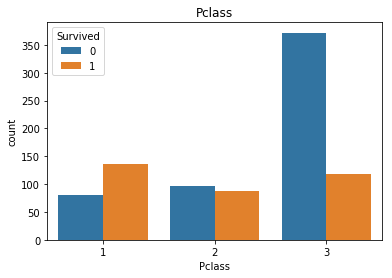

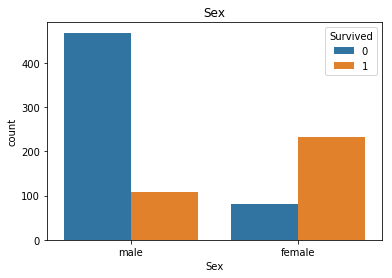

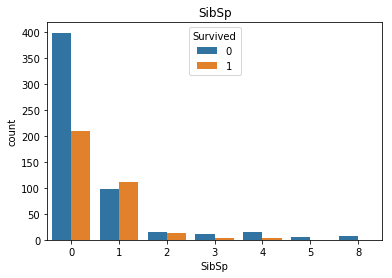

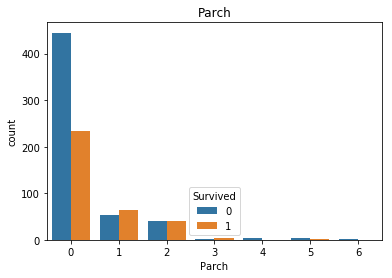

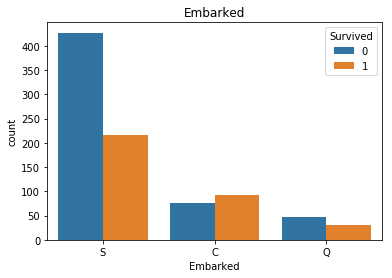

In [8]:
cols = ['Pclass', 'Sex', 'SibSp','Parch', 'Embarked']
for col in cols:
    plt.figure()
    sns.countplot(x=col, data = train, hue="Survived")
    plt.title(col)

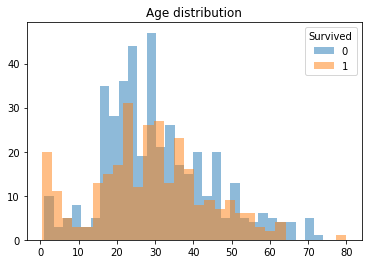

In [9]:
for status in train["Survived"].unique():
    plt.hist(x='Age',data=train[(train['Survived']==status) & (~train['Age'].isna())], alpha=0.5, label=status, bins=30)
    plt.title("Age distribution")
    plt.legend(title="Survived")

- Females and better Pclass (1 and 2) tend to have higher proportions of survivors
- Those not travelling with family (SibSp or Parch = 0) and those embarking at 'S' tend to have lower proportions of survivors

- Age appears to impact on the likelihood of survival, with a much higher proportion of survivors at the age ranges of 0-5 compared to other age groups

#### Data cleaning/wrangling
##### SibSp/Parch
From the prelim data analysis, passengers travelling without SibSp/Parch tend to have lower survival rates. A new column will be created to indicate whether passenger has any family(SipSp or Parch) on board. 

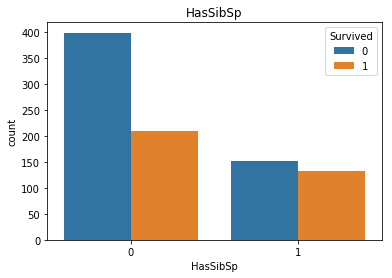

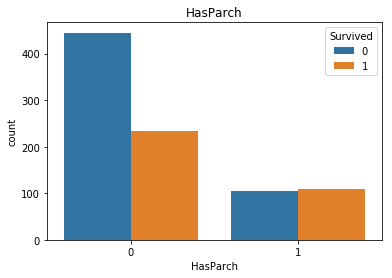

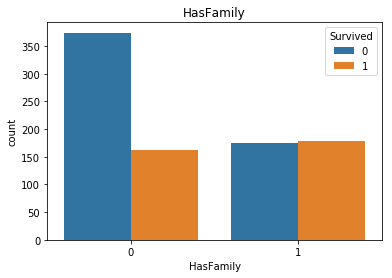

In [10]:
def transform_family_info(df):
    df["HasSibSp"] = 1
    df["HasParch"] = 1
    df["HasFamily"] = 1
    df.loc[df["SibSp"]==0,"HasSibSp"]=0
    df.loc[df["Parch"]==0,"HasParch"]=0
    df.loc[(df["HasSibSp"]==0)&(df["HasParch"]==0), "HasFamily"]=0
    
    return df


train = transform_family_info(train)

for col in ["HasSibSp","HasParch","HasFamily"]:
    plt.figure()
    sns.countplot(x=col, data = train, hue="Survived")
    plt.title(col)

There is a marked difference in survival rates for passengers with no family on board.'HasFamily' will be retained while 'HasSibSp' and 'HasParch' will be dropped as "Parch", "SibSp" and "HasFamily" would provide the same information.

##### Age
From the prelim data analysis, age appears to impact survival likelihood. 

The 'Name' column contains titles i.e. Mr, Mrs etc. This info may be useful for a differentiated approach in filling missing 'Age' values. For example, "Master" was a form of address for younger males in the early 20th century. We would also expect titles such as "Dr", "Col" and "Sir" to refer to more mature passengers.

'Title' will be extracted from the "Name" column and missing 'Age' values will be filled based on the median of that corresponding title.  This would avoid overestimating 'Age' for certain groups such as 'Master', which tend to have lower age values that are in the range where age has a big impact on survival likelihood.

In [11]:
train['title'] = train['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip()) #extract titles from names

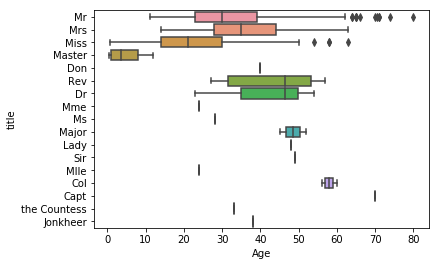

In [12]:
sns.boxplot(x="Age", y="title", data=train)    

The above figure confirms that there is some variation in age distributions for different titles. Missing 'Age' values will therefore be filled using the median age for the corresponding titles.

In [13]:
age_medians  = train.pivot_table(columns="title", aggfunc='median', values="Age") #create table of medians by title

age_medians['overall'] = train['Age'].median() #create an overall median age value. this helps to address missing values in test data which has no or new values for 'title'

def fill_age(df): #filling age NAs based with median age based on title, else with overall median age if no such title exists in age_medians
    title = df['title'].unique().item()
    try:
        df['Age'].fillna(age_medians.loc['Age',title], inplace=True)
    except:
        df['Age'].fillna(age_medians.loc['Age','overall'], inplace=True)
    return df

train = train.groupby('title').apply(lambda x: fill_age(x))

##### Cabin

According to [this wikipedia article](https://en.wikipedia.org/wiki/Sinking_of_the_RMS_Titanic#%22Iceberg_right_ahead!%22_(23:39)), the collision happened close to midnight, so most passengers had gone to bed. "Cabin" would be a good indication of where each passenger was at the time of collision, which would affect their chances of survival (i.e. access to life boats etc). 

'Cabin_Deck' and "Cabin_Number" can be extracted from "Cabin". Furthermore, according to [Titanic deckplans](https://www.encyclopedia-titanica.org/titanic-deckplans/), even-numbered cabins are located on one side of the ship and odd-numbered ones on the other. A 'Cabin_Number_Loc' column will be created to reflect this.



In [89]:
def get_cabin_info(df):
    
    #extract Cabin Deck and Number
    df['Cabin_Deck']= np.NaN
    df['Cabin_Number']= np.NaN
    df['Cabin_Number_Loc']= np.NaN
    df.loc[~df['Cabin'].isna(),'Cabin_Deck']  = df.loc[~df['Cabin'].isna(),'Cabin'].apply(lambda x:x[0]) #extract alphabet
    df.loc[~df['Cabin'].isna(), 'Cabin_Number']  = df.loc[~df['Cabin'].isna(), 'Cabin'].apply(lambda x:x[1:].split(' ')[0]) #retain only first booth number if entries have multiple booths
    df['Cabin_Number'] =  pd.to_numeric(df['Cabin_Number'], errors='coerce')
    df.loc[df['Cabin_Number']%2==0, 'Cabin_Number_Loc']="even"
    df.loc[df['Cabin_Number']%2==1, 'Cabin_Number_Loc']="odd"
    
    return df

train = get_cabin_info(train)

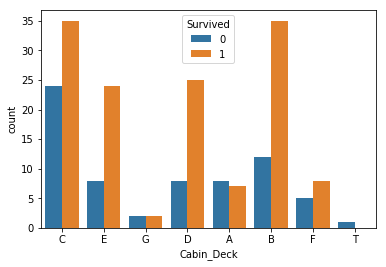

In [15]:
#sns.countplot(x='Cabin_Deck',data=train[~train['Cabin_Deck'].isna()],hue="Survived")
sns.countplot(x='Cabin_Deck',data=train[~train['Cabin_Deck'].isna()],hue="Survived")

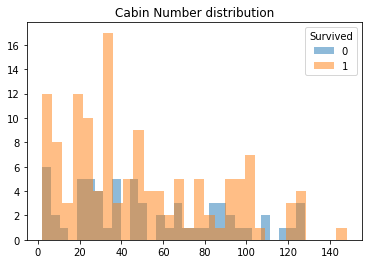

In [16]:
for status in train["Survived"].unique():
    plt.hist(x='Cabin_Number',data=train[(train['Survived']==status) & (~train['Cabin_Number'].isna())], alpha=0.5, label=status, bins=30)
    plt.title("Cabin Number distribution")
    plt.legend(title="Survived")

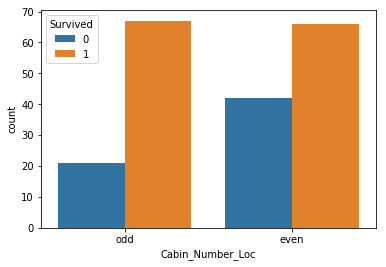

In [17]:
sns.countplot(x='Cabin_Number_Loc',data=train[~train['Cabin_Number_Loc'].isna()],hue="Survived")

In [18]:
train[['Cabin','Cabin_Deck','Cabin_Number','Cabin_Number_Loc']].nunique()

Cabin               147
Cabin_Deck            8
Cabin_Number         92
Cabin_Number_Loc      2
dtype: int64

Cabin location appears to have an impact on survival likelihood. Passengers on G, A and T Deck appear to be more likely to perish compared to other decks. Passengers with even numbered cabin numbers are also more likely to perish.

Unfortunately, over 75% of the cabin values are missing, and making assumptions about their values would significantly bias the modelling and lead to spurious results. It will also not work to create a new category for the missing values, as they necessarily belong to one of Decks A - G / T and have odd or even numbers in reality. The fact that cabin info is unknown also has no bearing on whether the passenger will survive at the time of the incident

##### Embarked

There were 2 missing values for Embarked, which will be filled with the mode

In [19]:
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode())

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
PassengerId         891 non-null int64
Survived            891 non-null object
Pclass              891 non-null object
Name                891 non-null object
Sex                 891 non-null object
Age                 891 non-null float64
SibSp               891 non-null int64
Parch               891 non-null int64
Ticket              891 non-null object
Fare                891 non-null float64
Cabin               204 non-null object
Embarked            889 non-null object
HasSibSp            891 non-null int64
HasParch            891 non-null int64
HasFamily           891 non-null int64
title               891 non-null object
Cabin_Deck          204 non-null object
Cabin_Number        196 non-null float64
Cabin_Number_Loc    196 non-null object
dtypes: float64(3), int64(6), object(10)
memory usage: 132.3+ KB


In [21]:
#Summarizing the data cleaning / preprocessing steps in a single function to facilitate processing of train and test data
def preproc(df):
    
    #fill missing age values
    df['title'] = df['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip()) #extract titles from names
    df = df.groupby('title').apply(lambda x: fill_age(x))
    
    #transform cabin info
    df = get_cabin_info(df) 
    
    #change Pclass to categorical var
    df['Pclass']=df['Pclass'].astype('str')
    
    #fill missing Embarked data
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode())
    
    #create categorical SibSp/Parch/Family columns
    transform_family_info(df)
    
    return df


#### Model Training



In [24]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [25]:
#include only variables of interest
variables = ["Pclass","Sex","Age","SibSp","Parch", "Embarked", "HasFamily"]
cat_var = ["Sex","Embarked","Pclass"]


X = train[variables]

X = pd.get_dummies(X, columns=cat_var)
y = train["Survived"]

#### Random Forest

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=11)
rf_model = RandomForestClassifier(random_state = 111)
rf_model.fit(X_train,y_train)
train_predictions = rf_model.predict(X_train)
test_predictions = rf_model.predict(X_test)

print("Training accuracy is {}".format(accuracy_score(y_train,train_predictions)))
print("Test accuracy is {}".format(accuracy_score(y_test,test_predictions)))
print("Confusion matrix for test set:\n{}".format(confusion_matrix(y_test,test_predictions)))

Training accuracy is 0.9261637239165329
Test accuracy is 0.8208955223880597
Confusion matrix for test set:
[[153  23]
 [ 25  67]]


/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test accuracy is ~82.1%. 

To get a more robust measure of how the model will perform on test set data, n-fold cross validation will be used. A grid search ois also done to find the optimal hyperparameters which maximizes the cross-validation score.

In [27]:
rf = RandomForestClassifier(random_state=111)

params = {'n_estimators': np.arange(50,250,50), 'min_samples_split':np.arange(2,10,2),'criterion':["gini","entropy"]}

rf_model_cv = GridSearchCV(rf, params, cv=StratifiedKFold(n_splits = 5, random_state=77), scoring='accuracy')
rf_model_cv.fit(X,y)
print("Cross validation score:{}".format(rf_model_cv.best_score_))
print("Best params:{}".format(rf_model_cv.best_params_))


Cross validation score:0.8170594837261503
Best params:{'criterion': 'entropy', 'min_samples_split': 8, 'n_estimators': 150}


The optimized model gives a cross validation score of 81.7%, close to the value obtained from using the base model on a simple train/test split. The optimized model using Gridsearch and n-fold cross validation is likely to be more generalizable to unseen data and will be used.

#### Logistic Regression

In [28]:
log = LogisticRegression(max_iter=500)

params = {'C':np.linspace(0.1,1,10), 'solver':['newton-cg', 'lbfgs', 'liblinear']}

log_model_cv = GridSearchCV(log, params, cv=StratifiedKFold(n_splits=5,random_state=77), scoring = "accuracy")
log_model_cv.fit(X,y)

print("Cross validation score:{}".format(log_model_cv.best_score_))
print("Best params:{}".format(log_model_cv.best_params_))

Cross validation score:0.8002244668911336
Best params:{'C': 0.4, 'solver': 'newton-cg'}


The optimized log regression model gives a cross validation score of 80%, slightly lower than that obtained with Random Forest.

#### Model Evaluation

In [71]:
#Get importances/weights of features 
feature_importance_rf = pd.Series(rf_model_cv.best_estimator_.feature_importances_, index = X.columns).sort_values(ascending=False)
weights_log = pd.Series(log_model_cv.best_estimator_.coef_.transpose()[:,0], index=X.columns).sort_values(ascending=False)


Text(0.5, 1.0, 'Feature Importances for Random Forest Model')

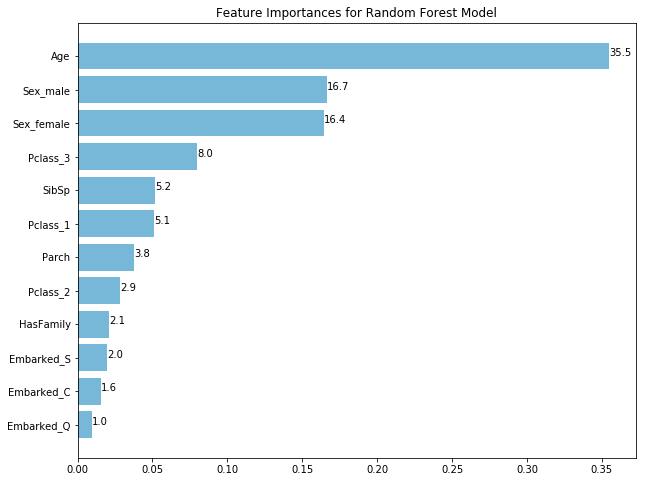

In [70]:
fig, ax = plt.subplots(figsize=(10,8))
ypos = np.arange(0,len(feature_importance_rf))[::-1]
ax.barh(ypos,feature_importance_rf.values, color='#77B7D8')

ax.set_yticks(ypos)
ax.set_yticklabels(feature_importance_rf.index)

for i,value in zip(ypos, feature_importance_rf.values):
    ax.annotate("{:.1f}".format(value*100), xy=(value, i))
    
plt.title("Feature Importances for Random Forest Model")

Text(0.5, 1.0, 'Coefficients for Log Regression Model')

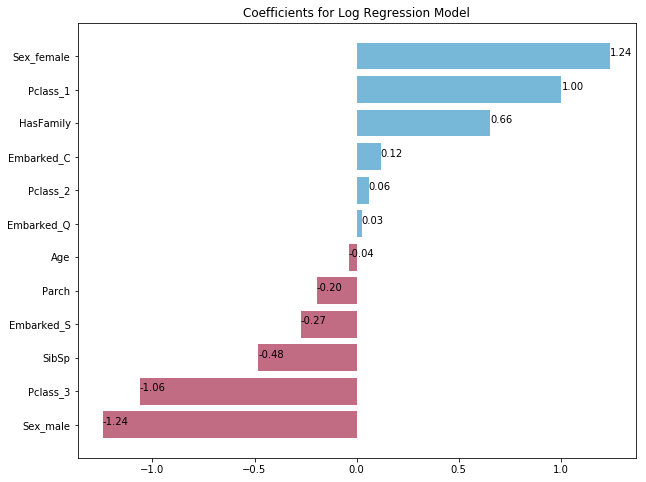

In [85]:
fig, ax = plt.subplots(figsize=(10,8))
ypos = np.arange(0,len(weights_log))[::-1]

positive_weights = weights_log[weights_log>=0]
ypos_positive = ypos[weights_log>=0]
negative_weights = weights_log[weights_log<0]
ypos_negative = ypos[weights_log<=0]
ax.barh(ypos_positive,positive_weights, color='#77B7D8')
ax.barh(ypos_negative,negative_weights, color='#C16C82')

ax.set_yticks(ypos)
ax.set_yticklabels(weights_log.index)

for i,value in zip(ypos, weights_log.values):
    ax.annotate("{:.2f}".format(value), xy=(value, i))
    
plt.title("Coefficients for Log Regression Model")

#### Conclusions

For both models, Pclass and Sex are important predictors. 

There are pronounced differences in the contribution of 'Age' and 'HasFamily' to the 2 models. 'Age' is the most important feature for RandomForest, whereas it has a relatively small coefficient in the logistic regression model. "HasFamily" has a relatively large weighting in the log regression model, whereas it is one of the less important features in random forest

Random Forest gave a better cross-validation score and is an ensemble method that would likely generalize better to unseen test data, as multiple estimators are used and predictions are averaged across the estimators. 

Logistic Regression on the other hand gives a more interpretable result, with the coefficients reflecting whether the features are negatively or positively correlated with survival.

For the purpose of maximizing prediction accuracy of unlabelled test set, the Random Forest model will be used. 


#### Predictions on unlabelled test set

In [86]:
test = pd.read_csv("test.csv")
test_cleaned = preproc(test) #preprocess test data in the same way as train
test_cleaned  = test_cleaned[variables]
test_cleaned  = pd.get_dummies(test_cleaned , columns=cat_var)


def add_missing_dummy_columns(train, test): #ensure test set has same columns as training set
    missing_cols = set(train.columns) - set(test.columns) 
    for c in missing_cols:
        test[c] = 0
    test = test[train.columns]
    return test

X_test = add_missing_dummy_columns(X,test_cleaned)


In [88]:
filename = "predictions.csv"

predictions = rf_model_cv.predict(X_test) 
predictions_df = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': predictions})
predictions_df.to_csv(filename, index=False)